<a href="https://colab.research.google.com/github/LauraHu820/CNN_image_classification/blob/main/CNN_CIFAR10_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display
import torch.nn.functional as F

In [ ]:
import os
os.cpu_count()

2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


Load and Preprocess data

In [ ]:
width, height = 224, 224
# define transfomation
train_transform = transforms.Compose([transforms.Resize((width, height)), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((width, height)), transforms.ToTensor(),

                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# load CIFAR10 data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [ ]:
# check the shape of input data: 3 channels, each has 224*224 data points
trainloader.dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# number of classes
testloader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Evaluation model

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

Training model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    for epoch in tqdm.tqdm(range(num_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # backward
            loss.backward()
            optimizer.step()

            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 64 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)

        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [ ]:
n_classes = 10

In [ ]:
# use resnet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.01)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 156 s, loss: 0.3926, acc: 86.5189


  5%|▌         | 1/20 [02:55<55:34, 175.48s/it]

Accuracy of the network on the test images: 89 %
Epoch 2, duration: 156 s, loss: 0.1877, acc: 93.5322


 10%|█         | 2/20 [05:50<52:36, 175.37s/it]

Accuracy of the network on the test images: 91 %
Epoch 3, duration: 156 s, loss: 0.1276, acc: 95.5643


 15%|█▌        | 3/20 [08:44<49:32, 174.85s/it]

Accuracy of the network on the test images: 93 %
Epoch 4, duration: 157 s, loss: 0.0955, acc: 96.5953


 20%|██        | 4/20 [11:39<46:36, 174.81s/it]

Accuracy of the network on the test images: 93 %
Epoch 5, duration: 156 s, loss: 0.0672, acc: 97.5583


 25%|██▌       | 5/20 [14:34<43:44, 174.95s/it]

Accuracy of the network on the test images: 92 %
Epoch 6, duration: 156 s, loss: 0.0299, acc: 98.9070


 30%|███       | 6/20 [17:29<40:48, 174.89s/it]

Accuracy of the network on the test images: 95 %
Epoch 7, duration: 157 s, loss: 0.0160, acc: 99.4266


 35%|███▌      | 7/20 [20:24<37:53, 174.89s/it]

Accuracy of the network on the test images: 95 %
Epoch 8, duration: 156 s, loss: 0.0124, acc: 99.5984


 40%|████      | 8/20 [23:20<35:00, 175.08s/it]

Accuracy of the network on the test images: 96 %
Epoch 9, duration: 157 s, loss: 0.0099, acc: 99.6723


 45%|████▌     | 9/20 [26:15<32:07, 175.26s/it]

Accuracy of the network on the test images: 95 %
Epoch 10, duration: 157 s, loss: 0.0076, acc: 99.7562


 50%|█████     | 10/20 [29:10<29:12, 175.21s/it]

Accuracy of the network on the test images: 96 %
Epoch 11, duration: 157 s, loss: 0.0071, acc: 99.7702


 55%|█████▌    | 11/20 [32:05<26:16, 175.18s/it]

Accuracy of the network on the test images: 96 %
Epoch 12, duration: 156 s, loss: 0.0071, acc: 99.7962


 60%|██████    | 12/20 [35:00<23:20, 175.07s/it]

Accuracy of the network on the test images: 96 %
Epoch 13, duration: 156 s, loss: 0.0071, acc: 99.7742


 65%|██████▌   | 13/20 [37:55<20:24, 174.89s/it]

Accuracy of the network on the test images: 96 %
Epoch 14, duration: 157 s, loss: 0.0069, acc: 99.7802


 70%|███████   | 14/20 [40:50<17:29, 174.91s/it]

Accuracy of the network on the test images: 96 %
Epoch 15, duration: 157 s, loss: 0.0067, acc: 99.8122


 75%|███████▌  | 15/20 [43:46<14:36, 175.36s/it]

Accuracy of the network on the test images: 96 %
Epoch 16, duration: 157 s, loss: 0.0069, acc: 99.7942


 80%|████████  | 16/20 [46:42<11:42, 175.54s/it]

Accuracy of the network on the test images: 96 %
Epoch 17, duration: 157 s, loss: 0.0078, acc: 99.7782


 85%|████████▌ | 17/20 [49:38<08:46, 175.51s/it]

Accuracy of the network on the test images: 96 %
Epoch 18, duration: 157 s, loss: 0.0070, acc: 99.7922


 90%|█████████ | 18/20 [52:34<05:51, 175.65s/it]

Accuracy of the network on the test images: 96 %
Epoch 19, duration: 157 s, loss: 0.0072, acc: 99.7742


 95%|█████████▌| 19/20 [55:30<02:55, 175.82s/it]

Accuracy of the network on the test images: 96 %
Epoch 20, duration: 157 s, loss: 0.0068, acc: 99.7922


100%|██████████| 20/20 [58:25<00:00, 175.26s/it]

Accuracy of the network on the test images: 96 %
Finished Training


Text(0.5, 1.0, 'Test acc')

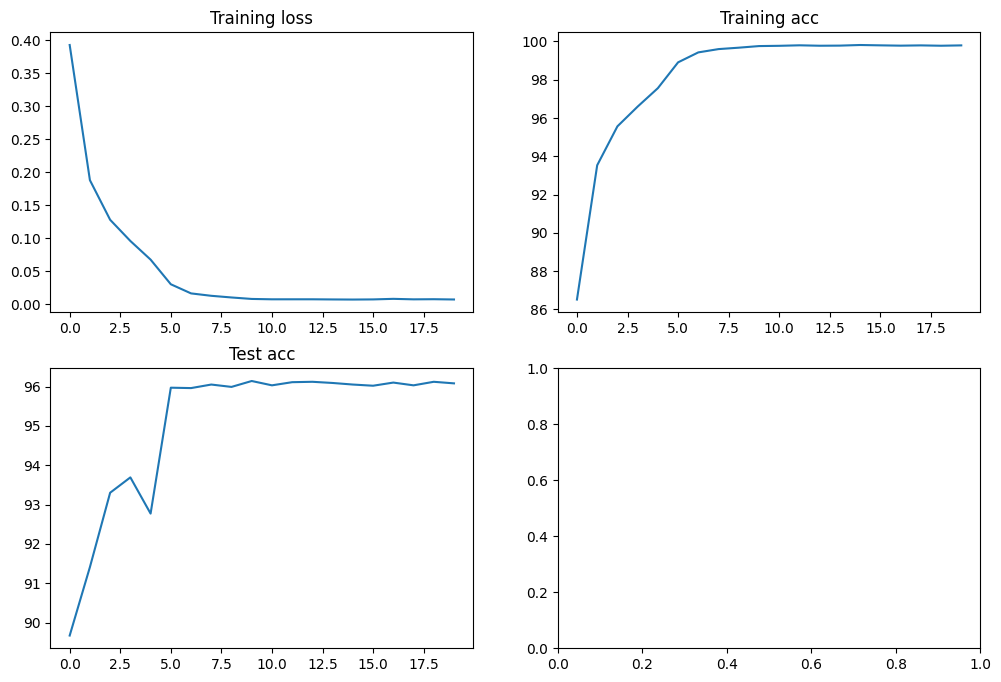

In [ ]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [ ]:
# use alexnet
model_ft_alx = models.alexnet(pretrained=True)
num_ftrs_alx = model_ft_alx.classifier[6].in_features
model_ft_alx.classifier[6] = nn.Linear(num_ftrs_alx, n_classes)
model_ft_alx = model_ft_alx.to(device)

criterion_alx = nn.CrossEntropyLoss()
optimizer_alx = optim.SGD(model_ft_alx.parameters(), lr=0.01, momentum=0.9)

lrscheduler_alx = optim.lr_scheduler.ReduceLROnPlateau(optimizer_alx, mode='max', patience=3, threshold = 0.01)

In [ ]:
model_ft_alx, training_losses_alx, training_accs_alx, test_accs_alx = train_model(model_ft_alx, criterion_alx, optimizer_alx, lrscheduler_alx, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 96 s, loss: 0.8410, acc: 71.0498


  5%|▌         | 1/20 [01:52<35:41, 112.74s/it]

Accuracy of the network on the test images: 80 %
Epoch 2, duration: 96 s, loss: 0.5476, acc: 81.3399


 10%|█         | 2/20 [03:46<33:56, 113.12s/it]

Accuracy of the network on the test images: 83 %
Epoch 3, duration: 94 s, loss: 0.4337, acc: 85.1303


 15%|█▌        | 3/20 [05:38<31:55, 112.65s/it]

Accuracy of the network on the test images: 85 %
Epoch 4, duration: 95 s, loss: 0.3829, acc: 86.6808


 20%|██        | 4/20 [07:30<30:00, 112.53s/it]

Accuracy of the network on the test images: 86 %
Epoch 5, duration: 95 s, loss: 0.3308, acc: 88.4171


 25%|██▌       | 5/20 [09:22<28:03, 112.22s/it]

Accuracy of the network on the test images: 86 %
Epoch 6, duration: 96 s, loss: 0.3030, acc: 89.4461


 30%|███       | 6/20 [11:14<26:12, 112.32s/it]

Accuracy of the network on the test images: 86 %
Epoch 7, duration: 93 s, loss: 0.2817, acc: 90.1914


 35%|███▌      | 7/20 [13:05<24:14, 111.92s/it]

Accuracy of the network on the test images: 87 %
Epoch 8, duration: 95 s, loss: 0.2488, acc: 91.3603


 40%|████      | 8/20 [14:57<22:21, 111.76s/it]

Accuracy of the network on the test images: 88 %
Epoch 9, duration: 96 s, loss: 0.2330, acc: 92.0237


 45%|████▌     | 9/20 [16:50<20:33, 112.15s/it]

Accuracy of the network on the test images: 88 %
Epoch 10, duration: 96 s, loss: 0.2175, acc: 92.4333


 50%|█████     | 10/20 [18:43<18:44, 112.42s/it]

Accuracy of the network on the test images: 87 %
Epoch 11, duration: 95 s, loss: 0.2136, acc: 92.6670


 55%|█████▌    | 11/20 [20:34<16:49, 112.16s/it]

Accuracy of the network on the test images: 87 %
Epoch 12, duration: 94 s, loss: 0.1939, acc: 93.2365


 60%|██████    | 12/20 [22:26<14:56, 112.00s/it]

Accuracy of the network on the test images: 87 %
Epoch 13, duration: 95 s, loss: 0.0907, acc: 96.7651


 65%|██████▌   | 13/20 [24:18<13:03, 111.87s/it]

Accuracy of the network on the test images: 91 %
Epoch 14, duration: 94 s, loss: 0.0606, acc: 97.9160


 70%|███████   | 14/20 [26:09<11:11, 111.86s/it]

Accuracy of the network on the test images: 91 %
Epoch 15, duration: 94 s, loss: 0.0482, acc: 98.2617


 75%|███████▌  | 15/20 [28:00<09:17, 111.42s/it]

Accuracy of the network on the test images: 91 %
Epoch 16, duration: 92 s, loss: 0.0437, acc: 98.3696


 80%|████████  | 16/20 [29:50<07:24, 111.04s/it]

Accuracy of the network on the test images: 91 %
Epoch 17, duration: 94 s, loss: 0.0366, acc: 98.6493


 85%|████████▌ | 17/20 [31:41<05:33, 111.14s/it]

Accuracy of the network on the test images: 91 %
Epoch 18, duration: 93 s, loss: 0.0306, acc: 98.8311


 90%|█████████ | 18/20 [33:32<03:41, 110.99s/it]

Accuracy of the network on the test images: 92 %
Epoch 19, duration: 94 s, loss: 0.0286, acc: 98.9670


 95%|█████████▌| 19/20 [35:23<01:50, 110.99s/it]

Accuracy of the network on the test images: 92 %
Epoch 20, duration: 94 s, loss: 0.0292, acc: 98.9330


100%|██████████| 20/20 [37:14<00:00, 111.72s/it]

Accuracy of the network on the test images: 92 %
Finished Training


Text(0.5, 1.0, 'alxnet Test acc')

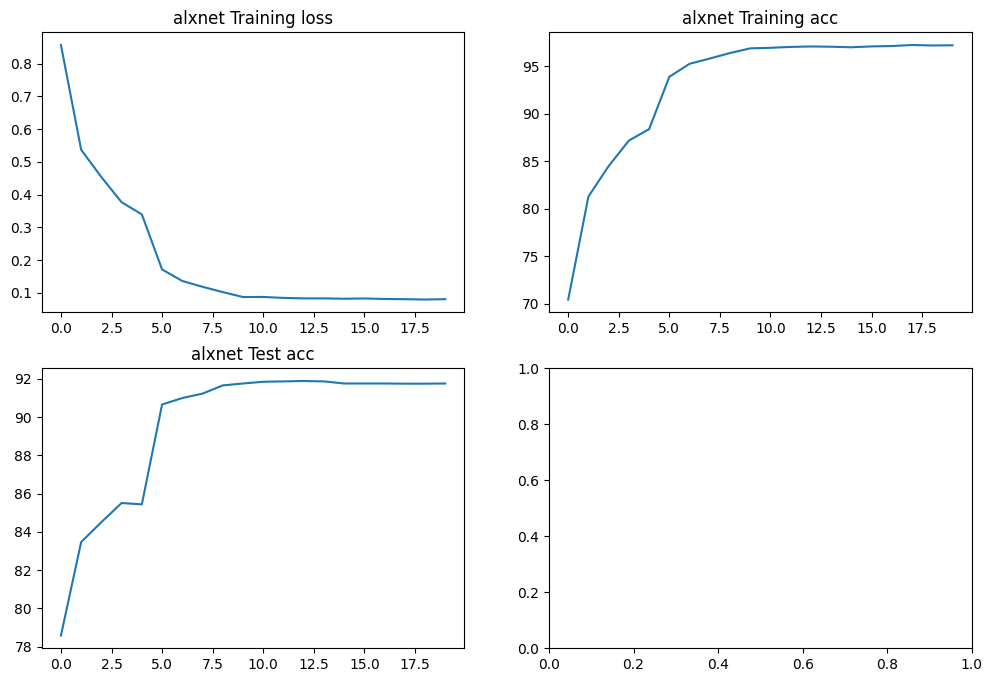

In [ ]:
# plot
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses_alx)
axarr[0, 0].set_title("alxnet Training loss")
axarr[0, 1].plot(training_accs_alx)
axarr[0, 1].set_title("alxnet Training acc")
axarr[1, 0].plot(test_accs_alx)
axarr[1, 0].set_title("alxnet Test acc")

build my own CNN

In [ ]:
class My_CNN(nn.Module):
  def __init__(self, conv1_num, conv2_num):
    super(My_CNN, self).__init__()
    self.conv1_num = conv1_num
    self.conv2_num = conv2_num

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_num, kernel_size=3, padding=1, stride=2)
    self.bn1 = nn.BatchNorm2d(conv1_num)

    self.conv2 = nn.Conv2d(in_channels=conv1_num, out_channels=conv2_num, kernel_size=3, padding=1, stride=2)
    self.bn2 = nn.BatchNorm2d(conv2_num)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.drop = nn.Dropout(p=0.25)

    self.fc1 = nn.Linear(in_features=conv2_num*14*14, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=n_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.drop(x)
    x = x.view(-1, self.conv2_num*14*14)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
my_cnn = My_CNN(16, 32).to(device)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(my_cnn.parameters(), lr=0.01, momentum=0.9)
lrscheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.01)

In [ ]:
model_ft_cnn, training_losses_cnn, training_accs_cnn, test_accs_cnn = train_model(my_cnn, criterion_cnn, optimizer_cnn, lrscheduler_cnn, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 82 s, loss: 1.4711, acc: 46.5034


  5%|▌         | 1/20 [01:38<31:08, 98.34s/it]

Accuracy of the network on the test images: 53 %
Epoch 2, duration: 83 s, loss: 1.2068, acc: 56.6656


 10%|█         | 2/20 [03:18<29:49, 99.40s/it]

Accuracy of the network on the test images: 58 %
Epoch 3, duration: 84 s, loss: 1.1107, acc: 60.3641


 15%|█▌        | 3/20 [04:58<28:13, 99.64s/it]

Accuracy of the network on the test images: 60 %
Epoch 4, duration: 82 s, loss: 1.0438, acc: 62.7458


 20%|██        | 4/20 [06:36<26:26, 99.18s/it]

Accuracy of the network on the test images: 61 %
Epoch 5, duration: 84 s, loss: 1.0003, acc: 64.4142


 25%|██▌       | 5/20 [08:16<24:51, 99.45s/it]

Accuracy of the network on the test images: 63 %
Epoch 6, duration: 83 s, loss: 0.9514, acc: 66.1785


 30%|███       | 6/20 [09:55<23:08, 99.16s/it]

Accuracy of the network on the test images: 63 %
Epoch 7, duration: 84 s, loss: 0.9094, acc: 67.5472


 35%|███▌      | 7/20 [11:35<21:31, 99.35s/it]

Accuracy of the network on the test images: 65 %
Epoch 8, duration: 83 s, loss: 0.8733, acc: 69.0437


 40%|████      | 8/20 [13:14<19:50, 99.22s/it]

Accuracy of the network on the test images: 65 %
Epoch 9, duration: 83 s, loss: 0.8340, acc: 70.4723


 45%|████▌     | 9/20 [14:53<18:12, 99.36s/it]

Accuracy of the network on the test images: 65 %
Epoch 10, duration: 83 s, loss: 0.8019, acc: 71.4334


 50%|█████     | 10/20 [16:32<16:30, 99.09s/it]

Accuracy of the network on the test images: 67 %
Epoch 11, duration: 84 s, loss: 0.7765, acc: 72.2986


 55%|█████▌    | 11/20 [18:13<14:57, 99.69s/it]

Accuracy of the network on the test images: 66 %
Epoch 12, duration: 84 s, loss: 0.7429, acc: 73.7272


 60%|██████    | 12/20 [19:53<13:19, 99.91s/it]

Accuracy of the network on the test images: 66 %
Epoch 13, duration: 85 s, loss: 0.7140, acc: 74.8022


 65%|██████▌   | 13/20 [21:34<11:41, 100.28s/it]

Accuracy of the network on the test images: 67 %
Epoch 14, duration: 86 s, loss: 0.6848, acc: 75.5295


 70%|███████   | 14/20 [23:16<10:04, 100.67s/it]

Accuracy of the network on the test images: 67 %
Epoch 15, duration: 83 s, loss: 0.6637, acc: 76.5685


 75%|███████▌  | 15/20 [24:56<08:22, 100.51s/it]

Accuracy of the network on the test images: 67 %
Epoch 16, duration: 86 s, loss: 0.6303, acc: 77.5775


 80%|████████  | 16/20 [26:39<06:45, 101.32s/it]

Accuracy of the network on the test images: 69 %
Epoch 17, duration: 84 s, loss: 0.6065, acc: 78.3228


 85%|████████▌ | 17/20 [28:20<05:03, 101.02s/it]

Accuracy of the network on the test images: 67 %
Epoch 18, duration: 85 s, loss: 0.5856, acc: 79.2519


 90%|█████████ | 18/20 [30:00<03:21, 100.87s/it]

Accuracy of the network on the test images: 68 %
Epoch 19, duration: 84 s, loss: 0.5569, acc: 80.2729


 95%|█████████▌| 19/20 [31:41<01:40, 100.79s/it]

Accuracy of the network on the test images: 68 %
Epoch 20, duration: 86 s, loss: 0.5446, acc: 80.6746


100%|██████████| 20/20 [33:23<00:00, 100.16s/it]

Accuracy of the network on the test images: 68 %
Finished Training
